# RESNET and Data analysis

In this notebook, we can see the Resnet code as well as some data_analisys.

In [10]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from skimage.io import imread
from skimage.segmentation import chan_vese, watershed
from skimage.draw import ellipse
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image

import os
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
import torch
from torch.nn.functional import relu


import os
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, resnet101, resnet50
from torch.optim.lr_scheduler import ReduceLROnPlateau


import matplotlib.pyplot as plt
import seaborn as sns


NaN counts:
ID             0
CLASS          0
SEX          284
AGE          324
POSITION    1970
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18998 entries, 0 to 18997
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        18998 non-null  object 
 1   CLASS     18998 non-null  int64  
 2   SEX       18714 non-null  object 
 3   AGE       18674 non-null  float64
 4   POSITION  17028 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 742.2+ KB


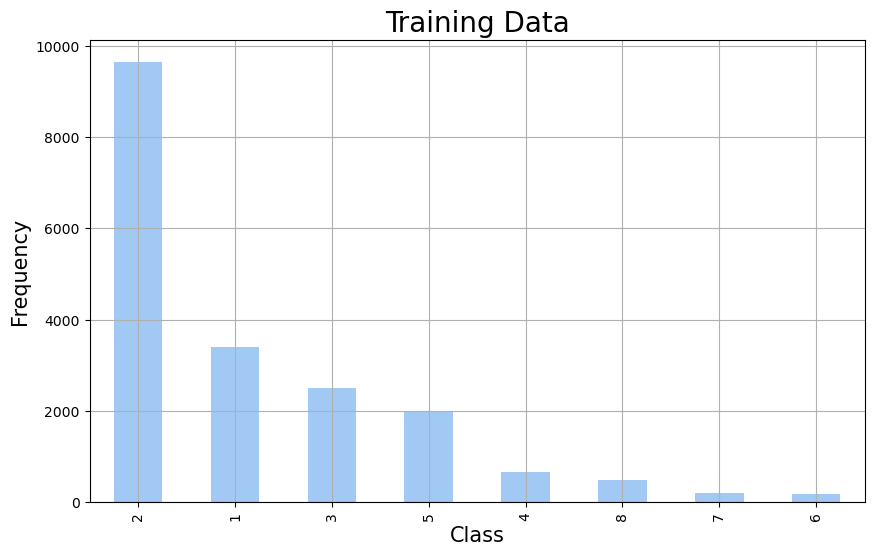

In [2]:
# Data Analysis
def preprocess_dataframe(df):
    # Performe one-hot encoding and drop the nan columns
    clean_df = pd.get_dummies(df, columns=['SEX', 'POSITION'], dummy_na=True, dtype=float)
    clean_df = clean_df.drop(columns=['SEX_nan', 'POSITION_nan'])
    # filling missing ages with the median age
    median_age = clean_df['AGE'].median()
    # print(f'Median age: {median_age}')
    clean_df.fillna({'AGE':median_age}, inplace=True)
    return clean_df

metadata_train = pd.read_csv('metadataTrain.csv')
metadata_test = pd.read_csv('metadataTest.csv')


# Function to compute NaN, isnull, and zero counts in each column
def compute_counts(df):
    nan_counts = df.isna().sum()
    isnull_counts = df.isnull().sum()
    return nan_counts, isnull_counts


# Compute NaN, isnull, and zero counts
nan_counts, isnull_counts = compute_counts(metadata_train)

# Display the counts
print("NaN counts:")
print(nan_counts)
metadata_train.info()
metadata_train = preprocess_dataframe(metadata_train)
metadata_test = preprocess_dataframe(metadata_test)



sns.set_palette("pastel")


ax = metadata_train['CLASS'].value_counts().plot(kind='bar', figsize=(10, 6))


ax.set_title('Training Data', fontsize=20)
ax.set_xlabel('Class', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)

ax.grid(True)

# Save the plot as an image file
plt.savefig('./training_data_plot.png', dpi=500)

plt.show()




# Resnet101

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, metadata, train, num_channels, transform=None):
        self.metadata = metadata
        self.root = root
        self.train = train
        self.transform = transform
        self.num_channels = num_channels

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        image_filename = self.metadata["ID"][index]

        image = Image.open(
            os.path.join(self.root, image_filename + ".jpg"), formats=["JPEG"]
        ).convert("RGB")

        if self.transform:
            image = self.transform(image)

        image = image[:self.num_channels]

        if self.train:
            label = self.metadata["CLASS"][index]
            return image, label

        return image
    


In [5]:

# Define the path 
root_dir = './Train/Train'
metadata_file = 'image_label.csv'

# Load metadata from CSV file
metadata = pd.read_csv(metadata_file)

metadata['CLASS'] = metadata['CLASS'] - 1

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


batch_size = 32

# Instantiate the CustomDataset for training or validation
train_dataset = CustomDataset(root_dir, metadata, train=True, num_channels=3, transform=transform)
train_len = int(len(train_dataset) * 0.8)
val_len = len(train_dataset) - train_len
train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [17]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(1))

cuda:1
Tesla V100S-PCIE-32GB


In [7]:

from tqdm import tqdm 
# Define ResNet model
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.resnet = resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet101
from tqdm import tqdm

# Define ResNet model
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.resnet = resnet101(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
num_classes = 8 # Number of classes
model = ResNetModel(num_classes)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

# Define loss function with weights
weights = torch.tensor([0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.000001)

# Initialize the scheduler
scheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

# Define early stopping parameters
early_stopping = False
best_val_loss = float('inf')
patience = 10
counter = 0

# Training loop
num_epochs=15
train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, position=0, leave=True)  # Create tqdm instance
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')  # Update tqdm description

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_running_loss = 0.0  # Initialize validation loss for this epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item() * inputs.size(0)

    val_accuracy = correct / total
    epoch_val_loss = val_running_loss / len(val_loader.dataset)

    # Append losses to lists
    train_losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {epoch_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}, '
          f'Validation Loss: {epoch_val_loss:.4f}')

    # Scheduler step
    scheduler.step(epoch_val_loss)

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            early_stopping = True
            break

if not early_stopping:
    print("Training completed without early stopping")

# Save train and validation losses
torch.save(train_losses, 'train_losses.pth')
torch.save(val_losses, 'val_losses.pth')



In [18]:
from tqdm import tqdm 
# Define ResNet model
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.resnet = resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, metadata, train, num_channels, transform=None):
        self.metadata = metadata
        self.root = root
        self.train = train
        self.transform = transform
        self.num_channels = num_channels

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        image_filename = self.metadata["ID"][index]

        image = Image.open(
            os.path.join(self.root, image_filename + ".jpg"), formats=["JPEG"]
        ).convert("RGB")

        if self.transform:
            image = self.transform(image)

        image = image[:self.num_channels]

        if self.train:
            label = self.metadata["CLASS"][index]
            return image, label

        return image
    


model_path = 'resnet_model.pth'
model.load_state_dict(torch.load(model_path))

model = model.to(device)

file_path = './metadataTest.csv'
metadata_test = pd.read_csv(file_path)
#print(metadata_test.head())

batch_size = 32
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


test_dir = './Test/Test'
test_data = CustomDataset(test_dir, metadata_test, train=False, num_channels=3, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Make predictions for the test data
predictions = []
for images in test_dataloader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
    predictions.extend(predicted_labels.cpu().numpy())

predictions = np.array(predictions) + 1

# Convert the predicted labels to a pandas DataFrame
test_results = pd.DataFrame({'ID': metadata_test['ID'], 'CLASS': predictions})

# Save the DataFrame to a CSV file
test_results.to_csv('test_results.csv', index=False)